# Lens model parameters recovery

Assess recovery of true lens model parameters when other are kept fixed at their true value.

In [1]:
import os
import sys
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.io.fits as pf
import pysap
import tqdm
import corner
import pickle as pkl

from lenstronomy.Data.psf import PSF
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import class_creator
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.ImSim.Numerics.grid import RegularGrid
from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit
from lenstronomy.Plots import chain_plot
from lenstronomy.Util import kernel_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util

from slitronomy.Lensing.lensing_operator import LensingOperator
from slitronomy.Util.plot_util import nice_colorbar, log_cmap

from TDLMCpipeline.Modelling.mask import ImageMask

np.random.seed(118)

n_points, n_points_zoom = 30, 50
subgrid_res_source = 2
use_likelihood_mask = True
parametric_ray_tracing = True
no_psf_convolution = False
skip_gamma = False
noise_seed_list = [101, 102, 103]  # or [None], seeds for multiple realizations of the noise

%matplotlib inline

In [2]:
def noise_with_SNR(snr_db, image, seed=None):
    if np.isinf(snr_db):
        return 0, np.zeros_like(image)
    if seed is not None:
        print("noise realization with seed: {}".format(seed), flush=True)
        np.random.seed(seed)
    sigma = np.linalg.norm(image.flatten(), 2) / snr_db
    noise = sigma * np.random.randn(*image.shape)
    return sigma, noise

def SDR(truth, model):
    """computes Source Distortion Ratio"""
    diff = truth - model
    return 10 * np.log10( np.linalg.norm(truth.flatten(), 2) / np.linalg.norm(diff.flatten(), 2) )

def norm(image, order):
    return np.linalg.norm(image.flatten(), ord=order)

def save_fig_list(base_name, fig_list, info_list, save_dir='loss_min_plots'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    for i, fig in enumerate(fig_list):
        fig_path = os.path.join(save_dir, f'{base_name}_{info_list[i]}.png')
        fig.savefig(fig_path, dpi=150)

In [3]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

In [4]:
# data specifics
num_pix = 99  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)

psf_fwhm = 0.2  # full width half max of PSF, in delta_pix units
psf_num_pix = 15

(15, 15)


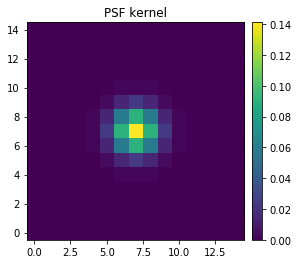

In [5]:
# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data_empty = {
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix))
}
data_class_tmp = ImageData(**kwargs_data_empty)

# PSF specification

if no_psf_convolution:
    kwargs_psf = {'psf_type': 'NONE'}
else:
    psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
    print(psf_kernel.shape)
    kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
psf_class = PSF(**kwargs_psf)

plt.title("PSF kernel")
im = plt.imshow(psf_class.kernel_point_source, origin='lower')
nice_colorbar(im)
plt.show()

In [6]:
# coordinates definition
image_grid  = RegularGrid(num_pix, num_pix, Mpix2coord, ra_at_xy_0, dec_at_xy_0)
source_grid = RegularGrid(num_pix, num_pix, Mpix2coord, ra_at_xy_0, dec_at_xy_0, 
                          supersampling_factor=subgrid_res_source)

ra_grid, dec_grid = image_grid.coordinates_evaluate
ra_grid_hd, dec_grid_hd = source_grid.coordinates_evaluate

In [7]:
lens_model_list = ['PEMD'] #, 'SHEAR_GAMMA_PSI']
kwargs_pemd = {'theta_E': 2, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}
#kwargs_shear = {'gamma_ext': 0.02, 'psi_ext': 0.5, 'ra_0': kwargs_pemd['center_x'], 'dec_0': kwargs_pemd['center_y']}
kwargs_lens = [kwargs_pemd]
if 'SHEAR_GAMMA_PSI' in lens_model_list:
    kwargs_lens.append(kwargs_shear)
lens_model_class = LensModel(lens_model_list=lens_model_list)

use_galsim_source = False
if use_galsim_source:
    # list of source light profiles from Galsim (COSMOS galaxy)
    source_dir = os.path.join('..', 'notebooks', 'data', 'sources')
    galsim_index = 1
    source_filename = 'source_galsim{}_pixsize{}mas_ssres{}.fits'.format(galsim_index, int(1000*delta_pix), subgrid_res_source)
    # load a source galaxy pre-generated with galsim
    with pf.open(os.path.join(source_dir, source_filename)) as f:
        galsim_source_subgrid = f[0].data
    # normalize so max is 1
    galsim_source_subgrid /= galsim_source_subgrid.max()
    galsim_delta_pix = image_grid.pixel_width / subgrid_res_source
    # light profile in lenstronomy conventions
    source_model_list = ['INTERPOL']
    # specify scale, centering and rotation angle for interpolation on source grid
    kwargs_interpol_source = {'image': galsim_source_subgrid, 
                              'amp': 500, 'center_x': +0.3, 'center_y': -0.1, 'phi_G': 0, 
                              'scale': galsim_delta_pix}
    kwargs_source = [kwargs_interpol_source]
    mock_name = f'galsim-{galsim_index}'
else:
    source_model_list = ['SERSIC']
    lensconfig_list = [
        ('cross', 0, 0),
        ('cusp', 0.1, 0.2),
        ('fold', 0.3, 0),
        ('double', 0.5, 0.5),
    ]
    idx_config = 3
    src_name, src_center_x, src_center_y = lensconfig_list[idx_config]
    kwargs_sersic_source = {'amp': 500, 'center_x': src_center_x, 'center_y': src_center_y, 'n_sersic': 1, 'R_sersic': 0.3}
    kwargs_source = [kwargs_sersic_source]
    mock_name = f'config-{src_name}'
source_model_class = LightModel(light_model_list=source_model_list)

kwargs_truth = {
    'kwargs_lens': kwargs_lens, 
    'kwargs_source': kwargs_source, 
    'kwargs_special': {'delta_x_source_grid': 0, 'delta_y_source_grid': 0},
}

## Generate true image of source

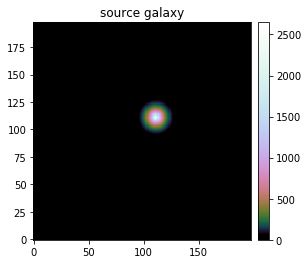

In [8]:
source_sim = source_model_class.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source)
source_sim = lenstro_util.array2image(source_sim)

plt.title("source galaxy")
im = plt.imshow(source_sim, origin='lower', cmap=log_cmap('cubehelix', 0.03, 1))
nice_colorbar(im)
plt.show()

In [9]:
if parametric_ray_tracing:
    # specify supersampling when doing parametric ray-tracing 
    kwargs_numerics_param = {'supersampling_factor': 3}
    imageModel = ImageModel(data_class_tmp, psf_class, lens_model_class, source_model_class, 
                            lens_light_model_class=None, point_source_class=None, 
                            kwargs_numerics=kwargs_numerics_param)
    # generate the image
    image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None)
else:
    imageModel = ImageModel(data_class_tmp, psf_class, lens_model_class, source_model_class, 
                            lens_light_model_class=None, point_source_class=None,
                            kwargs_numerics={'supersampling_factor': 1})
    # build the pixelated lensing operator
    lensing_op_sim = LensingOperator(lens_model_class, image_grid, source_grid, num_pix, subgrid_res_source,
                                     source_interpolation='bilinear')
    # ray tracing to generate the lensed source
    source_sim_1d = lenstro_util.image2array(source_sim)
    image_sim_no_noise_1d = lensing_op_sim.source2image(source_sim_1d, kwargs_lens=kwargs_lens)
    # PSF convolution
    image_sim_no_noise = imageModel.ImageNumerics.re_size_convolve(image_sim_no_noise_1d)


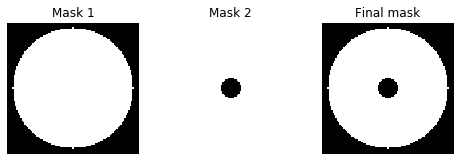

In [10]:
if use_likelihood_mask:
    # prepare mask
    mask_kwargs = {
        'mask_type': 'circle',
        'radius_list': [3.6] + [0.6], 
        'center_list': [None] + [None],
        'inverted_list': [False] + [True], 
        'operation_list': ['inter'],
    }
    imgMask = ImageMask(mask_shape=imageModel.Data.data.shape,
                        delta_pix=imageModel.Data.pixel_width,
                        **mask_kwargs)
    likelihood_mask = imgMask.get_mask(show_details=True)
    likelihood_mask_plot = likelihood_mask
else:
    likelihood_mask = None
    likelihood_mask_plot = np.ones_like(imageModel.Data.data)

## Display data at different SNR levels

inf 0
noise realization with seed: 101
500 0.23004695393725214


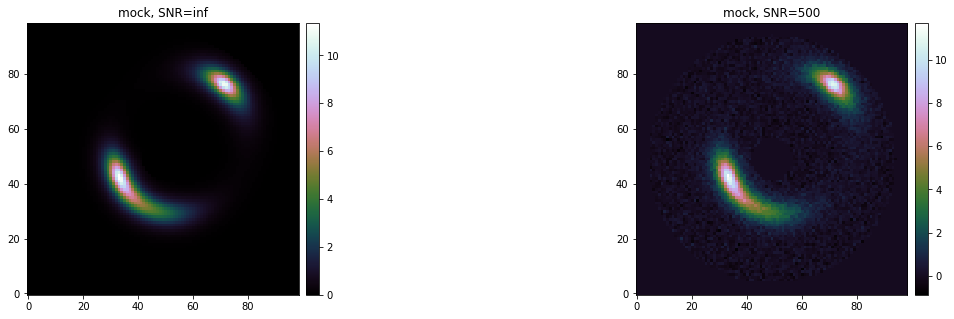

In [11]:
snr_range = [np.inf, 500]

bkg_rms_list = []
data_class_noisy_list = []
kwargs_data_noisy = copy.deepcopy(kwargs_data_empty)

fig = plt.figure(figsize=(20, 5))
for i, snr in enumerate(snr_range):
    sigma, noise = noise_with_SNR(snr, image_sim_no_noise, seed=noise_seed_list[0])
    print(snr, sigma)
    kwargs_data_noisy['image_data'] = image_sim_no_noise + noise
    kwargs_data_noisy['background_rms'] = sigma
    kwargs_data_noisy['noise_map'] = sigma * np.ones_like(image_sim_no_noise)
    dc = ImageData(**kwargs_data_noisy)
    data_class_noisy_list.append(dc)
    bkg_rms_list.append(sigma)

    ax = plt.subplot(1, len(snr_range), i+1)
    ax.set_title("mock, SNR={}".format(snr_range[i]))
    im = ax.imshow(lin_scale(dc.data)*likelihood_mask_plot, origin='lower', cmap='cubehelix') #, vmin=0)
    nice_colorbar(im)
plt.show()

# remove 'infinite' SNR for the tests
snr_range = snr_range[1:]
data_class_noisy_list = data_class_noisy_list[1:]
bkg_rms_list = bkg_rms_list[1:]


## Prepare solver

In [12]:
source_model_class_sparsefit = LightModel(['STARLETS'])
kwargs_source_sparsefit  = [{'n_scales': 6}]  # starlet coeffs that are optimized for

kwargs_sparse_solver = {
    'source_interpolation': 'bilinear',
    'include_regridding_error': False,
    'subgrid_res_source': subgrid_res_source,
    'sparsity_prior_norm': 1,
    'min_threshold': 3,
    'num_iter_source': 20,
    'num_iter_weights': 2,
    'verbose': False,
    'show_steps': False,
    'thread_count': 8,
}

Negative source pixels ? False (min = 0.00e+00)
Negative image pixels ? True (min = -9.47e-16)


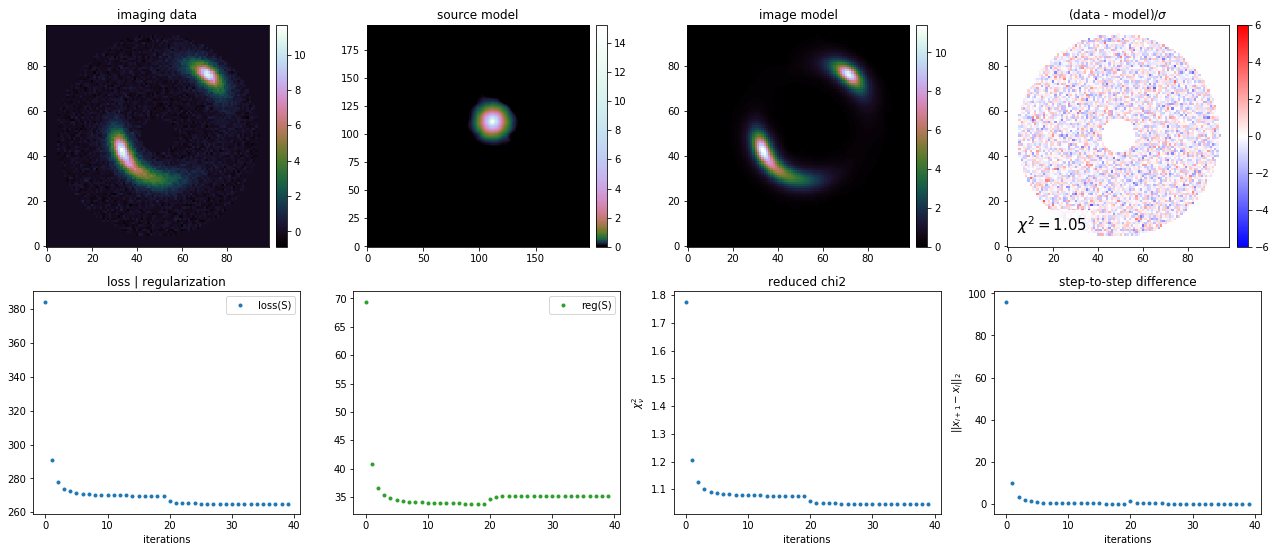

In [13]:
# test on the highest SNR to check for optimal settings
imageSparseFit_test = ImageSparseFit(data_class_noisy_list[-1], psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=likelihood_mask,
                                kwargs_sparse_solver=kwargs_sparse_solver)


solve_results = imageSparseFit_test.image_sparse_solve(kwargs_lens=kwargs_truth['kwargs_lens'],
                                                 kwargs_source=kwargs_source_sparsefit)
imageSparseFit_test.sparseSolver.plot_results(cmap_1=log_cmap('cubehelix', 1e-2, 1),
                                              cmap_2='cubehelix')
plt.show()

## Reconstructed source vs true source

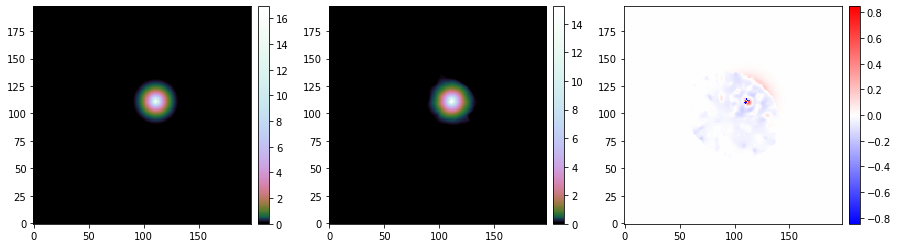

13.050796570294063


In [14]:
source_sim_comp = source_sim * subgrid_res_source**2 * (delta_pix/subgrid_res_source)**2
source_estim_comp = source_model_class_sparsefit.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_source_sparsefit)
source_estim_comp = lenstro_util.array2image(source_estim_comp)

fig = plt.figure(figsize=(15, 4))
ax = plt.subplot(1, 3, 1)
im = ax.imshow(source_sim_comp, origin='lower', cmap=log_cmap('cubehelix', 1e-2, 1))
nice_colorbar(im)
ax = plt.subplot(1, 3, 2)
im = ax.imshow(source_estim_comp, origin='lower', cmap=log_cmap('cubehelix', 1e-2, 1))
nice_colorbar(im)
ax = plt.subplot(1, 3, 3)
fraction_max_val = 0.05 * np.max(source_sim_comp)  # 5% of the true max flux
im = ax.imshow(source_sim_comp-source_estim_comp, origin='lower', cmap='bwr', 
               vmin=-fraction_max_val, vmax=fraction_max_val)
nice_colorbar(im)
plt.show()

print(SDR(source_sim_comp, source_estim_comp))

## One-parameter free tests

In [15]:
def vary_one_parameter(param_name, param_range, param_range_zoom=None, n_scales=6):
    if param_name in ['theta_E', 'gamma', 'e1', 'e2', 'center_x', 'center_y']:
        idx = lens_model_class.lens_model_list.index('PEMD')
    elif ['gamma_ext', 'psi_ext', 'ra_0', 'dec_0']:
        idx = lens_model_class.lens_model_list.index('SHEAR_GAMMA_PSI')
    else:
        raise ValueError("Wrong parameter name ?")
    
    # plot true value
    true_value = kwargs_truth['kwargs_lens'][idx][param_name]
    
    def _prepare_data_class(snr, noise_seed):
        """prepare data class with noise realization"""
        # generate background noise and update containers
        sigma_snr, noise_realiz = noise_with_SNR(snr, image_sim_no_noise, seed=noise_seed)
        kwargs_data_noisy = copy.deepcopy(kwargs_data_empty)
        kwargs_data_noisy['image_data'] = image_sim_no_noise + noise_realiz
        kwargs_data_noisy['background_rms'] = sigma_snr
        kwargs_data_noisy['noise_map'] = sigma_snr * np.ones_like(image_sim_no_noise)
        return ImageData(**kwargs_data_noisy)
    
    def _source4comparison(srcmodel, kwargs_src):
        """project reconstructed source on source plane grid for comparison with the truth"""
        srcmodel.delete_interpol_caches()  # don't forget that before generating the source
        source = srcmodel.surface_brightness(ra_grid_hd, dec_grid_hd, kwargs_src)
        return lenstro_util.array2image(source)
    
    def _iter_param(param_rge, imsim):
        """iterate over parameter values for a given range, solving the sparse optimization at each iteration"""
        metrics = {
            'image_chi2': [], 
            'loss': [], 
            'reg': [],
            'source_l1': [],
            'source_l2': [],
            'source_sdr': [],
        }
        for param_value in tqdm.tqdm(param_rge):
            kwargs_source_var = [{'n_scales': n_scales}]
            kwargs_lens_var = copy.deepcopy(kwargs_truth['kwargs_lens'])
            kwargs_lens_var[idx][param_name] = param_value
            _ = imsim.image_sparse_solve(kwargs_lens=kwargs_lens_var, kwargs_source=kwargs_source_var)
            S = imsim.sparseSolver.source_model
            metrics['image_chi2'].append(imsim.sparseSolver.best_fit_reduced_chi2)
            metrics['loss'].append(imsim.sparseSolver.loss(S=S))
            metrics['reg'].append(imsim.sparseSolver.regularization(S=S))
            metrics['source_l1'].append(norm(S, 1))
            metrics['source_l2'].append(norm(S, 2))
            source_comp = _source4comparison(imsim.SourceModel, kwargs_source_var)
            metrics['source_sdr'].append(SDR(source_sim_comp, source_comp))
        return metrics
    
    def _plot_panel(ax, ax_inset, metrics_data, metrics_data_inset, var_name, latex_name, 
                   loc_inset='upper right', xlabel=True, reference_data=True):
        # put labels and other indications
        if reference_data:
            ax.set_title(latex_name, fontsize=14)
            if xlabel:
                ax.set_xlabel("{}".format(param_name))
            ax.set_ylabel(latex_name)
            ax.axvline(true_value, linestyle='--', color='gray')
            if metrics_data_inset is not None:
                ax_inset = inset_axes(ax, width='50%', height='40%', loc=loc_inset)
                ax_inset.axvline(true_value, linestyle='--', color='gray', linewidth=1)
            else:
                ax_inset = None
            color, alpha, zorder = '#1f77b4', 1, 10
        else:
            color, alpha, zorder = 'black', 0.2, 9
        # plot data
        ax.plot(param_range, metrics_data[var_name], linestyle='-', color=color, alpha=alpha, zorder=zorder)
        if ax_inset is not None:
            ax_inset.plot(param_range_zoom, metrics_data_inset[var_name], linestyle='-', color=color, alpha=alpha, zorder=zorder)
        return ax, ax_inset
    
    ##################### iterate over SNR #####################
    fig_list = []
    for s, snr in enumerate(snr_range):
        print("SNR: {}".format(snr), flush=True)
        
        # init the figure
        fig, axes = plt.subplots(2, 3, figsize=(14, 9))
        fig.suptitle("parameter varying: '{}'".format(param_name), fontsize=16)
        axes = axes.reshape(6)
        axes_z = [None]*len(axes)

        #################### iterate over noise realizations ####################
        for n, noise_seed in enumerate(noise_seed_list):
            # update data_class with noise
            data_class_noisy = _prepare_data_class(snr, noise_seed)

            # solve for each parameter
            src_model_class = LightModel(['STARLETS'])
            im_sim = ImageSparseFit(data_class_noisy, psf_class, 
                                    lens_model_class=lens_model_class,
                                    source_model_class=src_model_class,
                                    likelihood_mask=likelihood_mask,
                                    kwargs_sparse_solver=kwargs_sparse_solver)

            # iterate over the parameter range
            summary = _iter_param(param_range, im_sim)

            # iterate over the parameter range on a reduced range
            if param_range_zoom is not None:
                summary_zoom = _iter_param(param_range_zoom, im_sim)
            else:
                summary_zoom = None

            # plot each metric in a separate panel
            ref_model = (n == 0)   # take the 'reference' as the first realization
            axes[0], axes_z[0] = _plot_panel(axes[0], axes_z[0], summary, summary_zoom, 'image_chi2', "image reduced $\chi^2$", xlabel=False, reference_data=ref_model)
            axes[1], axes_z[1] = _plot_panel(axes[1], axes_z[1], summary, summary_zoom, 'loss', "loss", xlabel=False, reference_data=ref_model)
            axes[2], axes_z[2] = _plot_panel(axes[2], axes_z[2], summary, summary_zoom, 'reg', "starlets regularization", xlabel=False, reference_data=ref_model)
            axes[3], axes_z[3] = _plot_panel(axes[3], axes_z[3], summary, summary_zoom, 'source_l1', "source $\ell_1$-norm", reference_data=ref_model)
            axes[4], axes_z[4] = _plot_panel(axes[4], axes_z[4], summary, summary_zoom, 'source_l2', "source $\ell_2$-norm", reference_data=ref_model)
            axes[5], axes_z[5] = _plot_panel(axes[5], axes_z[5], summary, summary_zoom, 'source_sdr', "source SDR", loc_inset='lower right', reference_data=ref_model)
        
        fig_list.append(fig)
    
    # save figure in default directory
    save_fig_list(f'{mock_name}_{param_name}_snr', fig_list, snr_range)
    return fig_list


### Vary projected mass slope

SNR: 500
noise realization with seed: 101


100%|██████████| 50/50 [00:52<00:00,  1.35s/it]

noise realization with seed: 102



100%|██████████| 50/50 [00:50<00:00,  1.05s/it]

noise realization with seed: 103



100%|██████████| 50/50 [00:52<00:00,  1.01s/it]


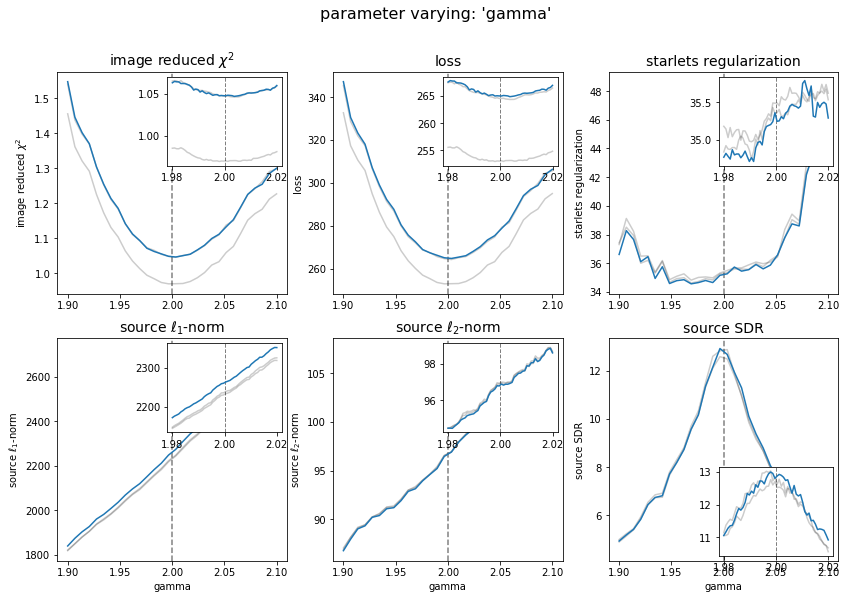

In [16]:
if not skip_gamma:
    truth = kwargs_truth['kwargs_lens'][0]['gamma']
    fig_list = vary_one_parameter('gamma', np.linspace(truth-0.1, truth+0.1, n_points), 
                                  param_range_zoom=np.linspace(truth-0.02, truth+0.02, n_points_zoom))
    plt.show()

### Vary Einstein radius

SNR: 500
noise realization with seed: 101


100%|██████████| 50/50 [00:50<00:00,  1.02s/it]

noise realization with seed: 102



100%|██████████| 50/50 [00:51<00:00,  1.01s/it]

noise realization with seed: 103



100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


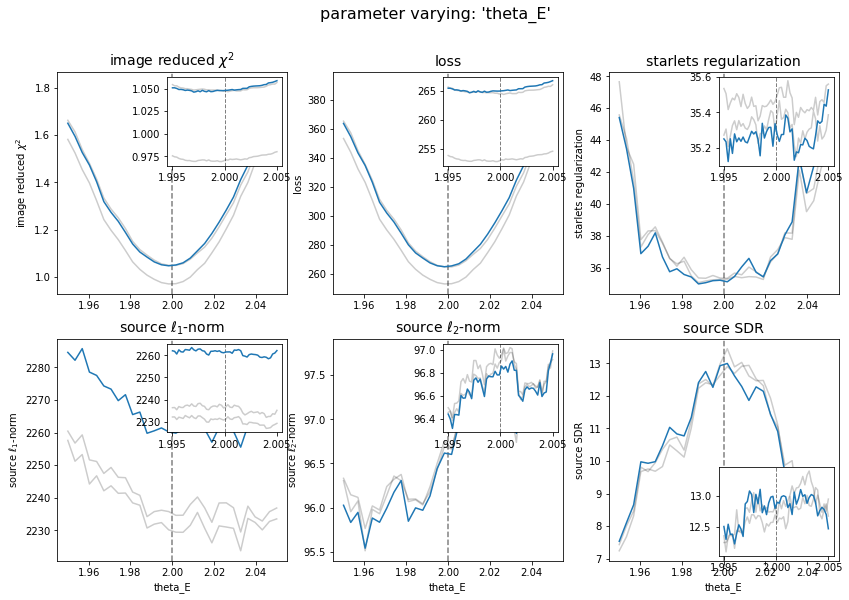

In [17]:
truth = kwargs_truth['kwargs_lens'][0]['theta_E']
fig_list = vary_one_parameter('theta_E', np.linspace(truth-0.05, truth+0.05, n_points), 
                              param_range_zoom=np.linspace(truth-0.005, truth+0.005, n_points_zoom))
plt.show()

### Vary ellipticities

SNR: 500
noise realization with seed: 101


100%|██████████| 50/50 [00:50<00:00,  1.00it/s]

noise realization with seed: 102



100%|██████████| 50/50 [00:50<00:00,  1.00s/it]

noise realization with seed: 103



100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


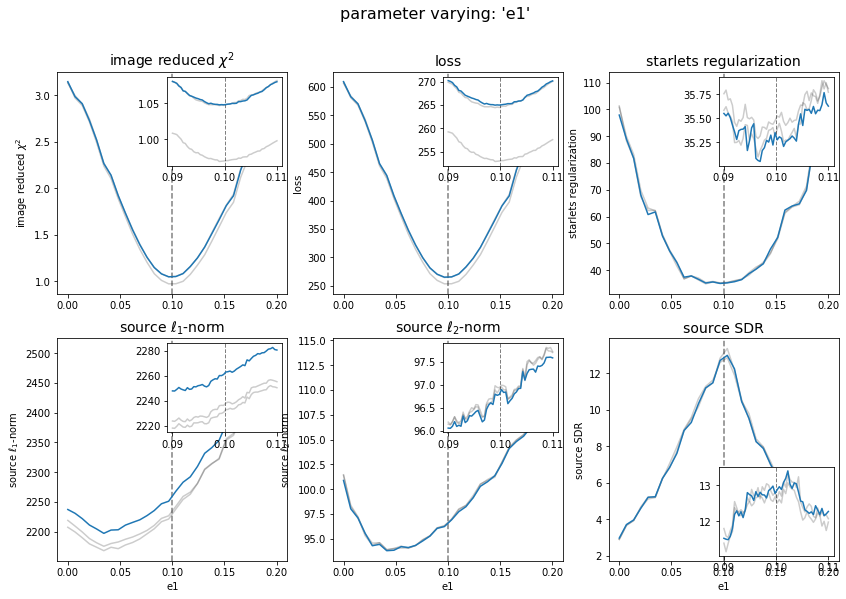

SNR: 500
noise realization with seed: 101


100%|██████████| 50/50 [00:49<00:00,  1.04it/s]

noise realization with seed: 102



100%|██████████| 50/50 [00:51<00:00,  1.04s/it]

noise realization with seed: 103



100%|██████████| 50/50 [00:49<00:00,  1.04it/s]


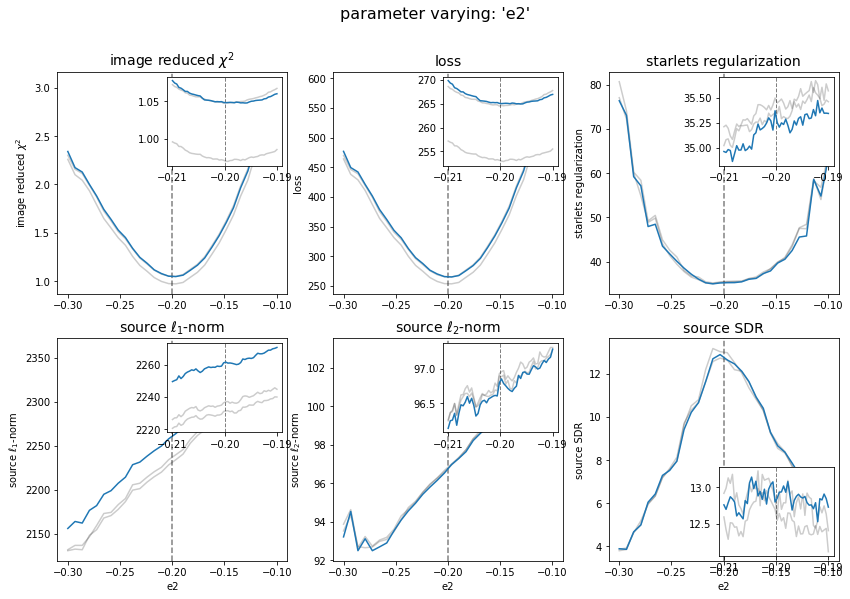

In [18]:
truth = kwargs_truth['kwargs_lens'][0]['e1']
fig_list = vary_one_parameter('e1', np.linspace(truth-0.1, truth+0.1, n_points), 
                               param_range_zoom=np.linspace(truth-0.01, truth+0.01, n_points_zoom))
plt.show()
truth = kwargs_truth['kwargs_lens'][0]['e2']
fig_list = vary_one_parameter('e2', np.linspace(truth-0.1, truth+0.1, n_points), 
                               param_range_zoom=np.linspace(truth-0.01, truth+0.01, n_points_zoom))
plt.show()

### Vary centroid position

SNR: 500
noise realization with seed: 101


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]

noise realization with seed: 102



100%|██████████| 50/50 [00:49<00:00,  1.00it/s]

noise realization with seed: 103



100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


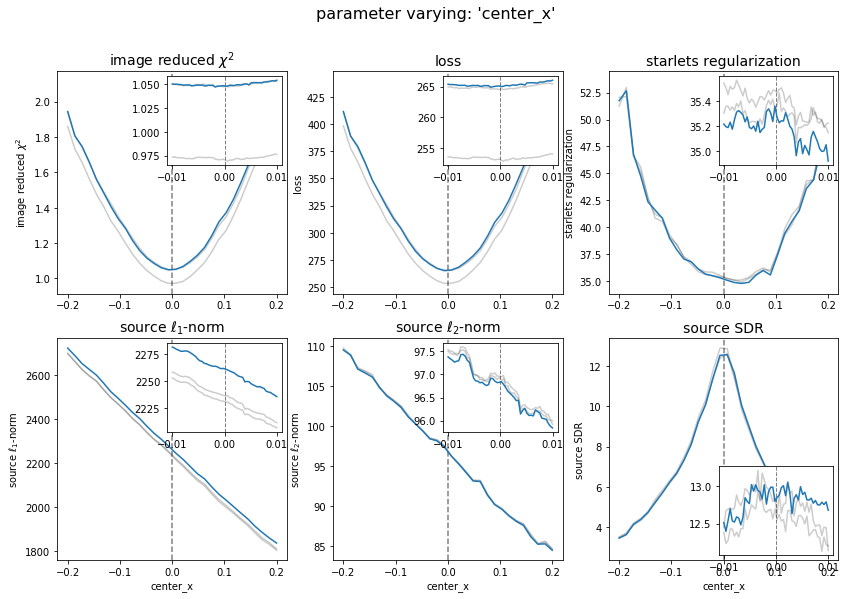

SNR: 500
noise realization with seed: 101


100%|██████████| 50/50 [00:47<00:00,  1.05it/s]

noise realization with seed: 102



100%|██████████| 50/50 [00:47<00:00,  1.06it/s]

noise realization with seed: 103



100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


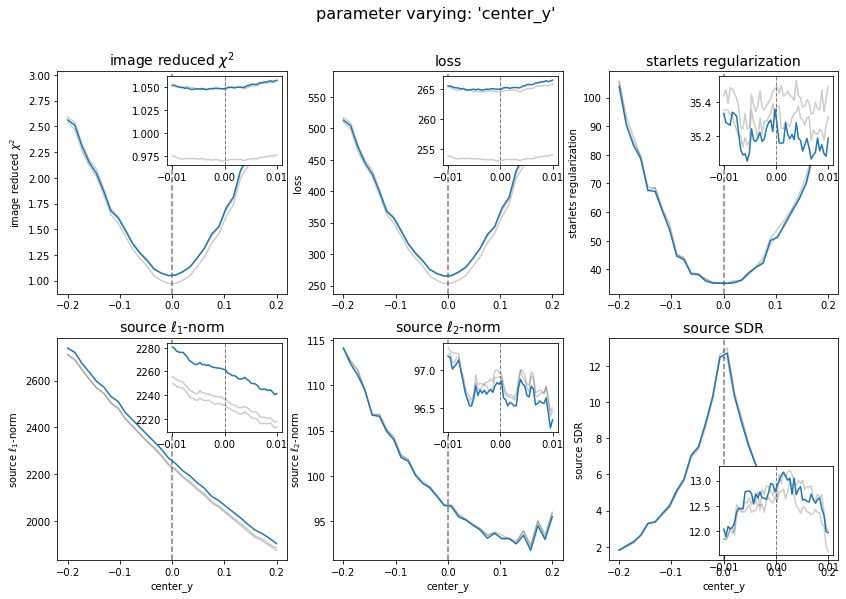

In [19]:
truth = kwargs_truth['kwargs_lens'][0]['center_x']
fig_list = vary_one_parameter('center_x', np.linspace(truth-0.2, truth+0.2, n_points), 
                              param_range_zoom=np.linspace(truth-0.01, truth+0.01, n_points_zoom))
plt.show()
truth = kwargs_truth['kwargs_lens'][0]['center_y']
fig_list = vary_one_parameter('center_y', np.linspace(truth-0.2, truth+0.2, n_points), 
                              param_range_zoom=np.linspace(truth-0.01, truth+0.01, n_points_zoom))
plt.show()

### Vary external shear

In [20]:
if 'SHEAR_GAMMA_PSI' in lens_model_list:
    truth = kwargs_truth['kwargs_lens'][1]['gamma_ext']
    fig_list = vary_one_parameter('gamma_ext', np.linspace(0, 0.2, n_points), 
                                  param_range_zoom=np.linspace(max(0, truth-0.005), 
                                                             min(1, truth+0.005), n_points_zoom))
    plt.show()
    truth = kwargs_truth['kwargs_lens'][1]['psi_ext']
    fig_list = vary_one_parameter('psi_ext', np.linspace(-np.pi/2, np.pi/2, n_points), 
                                  param_range_zoom=np.linspace(truth-0.05, truth+0.05, n_points_zoom))
    plt.show()